# Multilayer Neural Networks with PyTorch 

<hr style="border:2px solid gray">

# Index: <a id='index'></a>
1. [PyTorch](#pytorch)
1. [Generating Data and Setting Up](#setup)
1. [Revisiting the Single Neuron Binary Classifier](#binary)
1. [Training](#training)
1. [Multilayer Perceptron](#multi)
1. [Training the Multilayer network](#trainmulti)
1. [Conclusion](#conc)
1. [Appendix](#app)
    1. [Coordinate Transformation](#coord)
    1. [PyTorch backward() Function](#backward_app)

<hr style="border:2px solid gray">

# PyTorch [^](#index) <a id='pytorch'></a> 

Welcome to the wonderful world of PyTorch! 

There are a lot of sharp edges, but PyTorch is still arugably the most seamless package for building neural networks.

[Documentation](https://pytorch.org/docs/stable/nn.html)

We will firstly import `torch` and `torch.nn`. Note that module to import is not called pytorch - just torch.

In [2]:
import torch
import torch.nn as nn

torch.manual_seed(31337) # for reproducible runs, manually set the PRNG seed

## Tensors 

PyTorch works exclusively with its own datatype similar to a numpy array, known as a **tensor**.
Tensors are all encompassing, in the sense that data structures of any dimension can be tensors.

- Scalars  - Rank 0 Tensors
- Vectors  - Rank 1 Tensors
- Matrices - Rank 2 Tensors etc.

The simplest way to create a tensor is to use `torch.tensor()` and pass in data in the same way you would with a numpy array.

Tensors, similar to numpy arrays, **can only store a single datatype**. This means that the type stored in a tensor is a property of that object.

When you create a tensor, you can specify the datatype it stores using the `dtype` keyword argument. The documentation for PyTorch tensors has a [list of datatypes](https://pytorch.org/docs/stable/tensors.html#data-types).

<div style="background-color:#C2F5DD">
    
Create a tensor of any shape without specifying datatype. What is the default datatype? Does it depend on the type you use to create the tensor?

<div style="background-color:#C2F5DD">

Check the type of data contained using `.dtype` and the type of tensor using `.type()`. Note the brackets after the type attribute. 

</div>
    
The documentation linked above also contains details on types of tensors themselves.

In [6]:
tmp = torch.tensor([1, 2, 3])
tmp.dtype

torch.int64

In [7]:
tmp.type()

'torch.LongTensor'

PyTorch provides methods to create empty, all 0s, all 1s and random-valued tensors.

In [8]:
empty = torch.empty(3,5)
ran = torch.rand(2,4)
zeros = torch.zeros(2,3,4)
ones = torch.ones(6)

print(f'empty tensor with shape {empty.shape}:\n\n{empty}\n')
print(f'random tensor with shape {ran.shape}:\n\n{ran}\n')
print(f'zeros tensor with shape {zeros.shape}:\n\n{zeros}\n')
print(f'ones tensor with shape {ones.shape}:\n\n{ones}')

empty tensor with shape torch.Size([3, 5]):

tensor([[-2.4299e+27,  3.0670e-41,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]])

random tensor with shape torch.Size([2, 4]):

tensor([[0.7941, 0.4809, 0.4088, 0.4594],
        [0.9966, 0.4029, 0.8646, 0.1313]])

zeros tensor with shape torch.Size([2, 3, 4]):

tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]])

ones tensor with shape torch.Size([6]):

tensor([1., 1., 1., 1., 1., 1.])


An important keyword we can specify is `requires_grad`. The default value is false. This must be set to true for tensors which are involved in the training process. Recall that the computation of gradients is a key part of the optimization process using gradient descent, or any other optimizer. More on this later.

In [9]:
torch.tensor([8,9]).requires_grad

False

<div style="background-color: #FFF8C6">

Those who have a GPU on their computer can use the cell below to check whether CUDA is available. Read about CUDA [here](https://blogs.nvidia.com/blog/2012/09/10/what-is-cuda-2/).

In [10]:
# Do we have GPU acceleration?
torch.cuda.is_available()

False

## Linear Layer

The first thing we will build is a [linear layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html). Data which is fed into a linear layer is linearly transformed, but not passed through an activation function.

To do this, we must specify the number of input 'legs' and output 'legs'.

`nn.linear` will generate random weights and biases (here specified by our random seed)

In [11]:
m=2 # the number of input legs
n=1 # the number of output legs

linearlayer = nn.Linear(m,n)

We can call the function on a rank 1 tensor of length 2 (since there are 2 input legs), which should produce a rank 0 tensor, a.k.a. a scalar (since there is just 1 output leg).

In [12]:
linearlayer(torch.Tensor([1,1]))

tensor([0.4722], grad_fn=<ViewBackward0>)

Above, we passed 1 instance of data which has 2 features, from which our linear layer produced 1 output. We'll now pass 20 instances of data, so our output should have shape (20,1).


In [13]:
rt=torch.randn(20, m) 

In [14]:
linearlayer(rt).shape # pass through the linear layer

torch.Size([20, 1])

### Inspecting the model

We can look at the weights and the biases of our model.
The model is an object, so has both data and method attributes.

In [15]:
print("W", linearlayer.weight)
print("b", linearlayer.bias)

W Parameter containing:
tensor([[-0.5175,  0.3412]], requires_grad=True)
b Parameter containing:
tensor([0.6485], requires_grad=True)


You will notice the `requires_grad` keyword here. This must be set to True for a tensor if we are going to require the gradient to be calculated at any point in its existence. For weights and biases in a neural network, we definitely need this to be True, as the training process requires computation of gradients.

<hr style="border:2px solid gray">

# Generating Data and Setting Up [^](#index) <a id='setup'></a>

We will import relevant modules, set the plotting parameters for the notebook and generate a toy dataset to work with.

In [16]:
import sklearn, sklearn.datasets
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [3,3]
plt.rcParams['figure.dpi'] = 200 


Generating a toy dataset:

(We use a random seed here to ensure reproducible runs, making debugging possible)

In [17]:
n_samples=200
np.random.seed(0)

In [18]:
X,Y=sklearn.datasets.make_classification(n_features=2, n_redundant=0, n_samples=n_samples,
    n_informative=2, random_state=None, n_clusters_per_class=1)

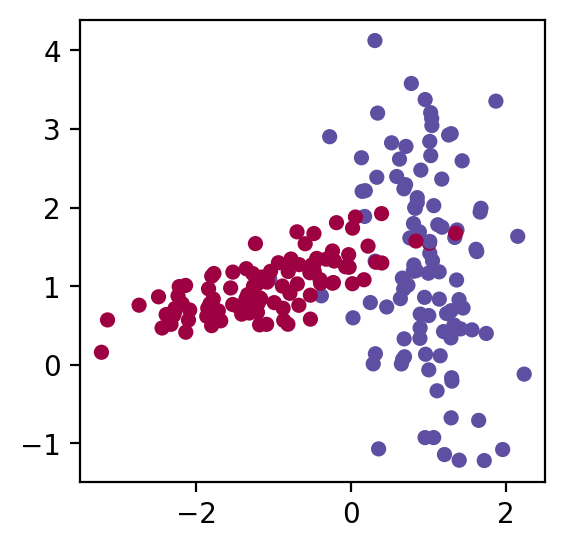

In [19]:
plt.scatter(X[:,0],X[:,1], c=Y, s=20, cmap=plt.cm.Spectral)

<hr style="border:2px solid gray">

# Revisiting the Single Neuron Binary Classifier [^](#index) <a id='binary'></a> 

We will now recreate the binary classifier we made previously, now we have the full power of Pytorch to train it efficiently.

Previously we had to implement all of the training steps ourselves from scratch - this time we will make use of the convenient built-in functionality in PyTorch.


We need a model which consists of the linear layer from above, but with a Sigmoid activation function. When building a model, `nn.Sequential` allows you to specify all the layers and activation functions in order. E.g., below we pass our linear layer followed by the sigmoid function. The output from one layer becomes the input to the next one. The convenience of this feature becomes more apparent as the networks you build get bigger.

In [20]:
input_size=2 # two dimensional input
output_size=1 # one output

# Output from one activation function becomes the input for the next, chained together by forward() functions

model = nn.Sequential(nn.Linear(input_size,output_size), nn.Sigmoid())

print(model) 

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)


<div style="background-color: #FFF8C6">

There is an alternative way to build arbitrary models in 
PyTorch by constructing a Python class, but this is considerably more complicated, involves a lot of 
object-orientated boilerplate code, and isn't necessary for 
simple architectures such as these.

As before with our linear layer, we input 2 arbitrary values, which should generate a scalar output


In [21]:
model(torch.tensor([0.0,0.0])) 

tensor([0.5912], grad_fn=<SigmoidBackward0>)

<hr style="border:2px solid gray">

# Training [^](#index) <a id='training'></a>

We will now train our neural network. For this, we need to define a loss function.
<div style="background-color:#C2F5DD">
    
See [the documentation from pytorch on loss functions](https://pytorch.org/docs/stable/nn.html#loss-functions) to find an applicable loss function and implement it below.
How does this compare to the self-coded loss function from the previous notebook? 

In [37]:
loss_function = nn.NLLLoss() # negative log likelihood loss function

When building a neural network in PyTorch, we need to define an optimizer. Recall that the training process often boils down to a multivariate minimisation problem - there are many pre-built algorithms which can carry this out for us efficiently. We will be using **stochastic gradient descent**.

In [24]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.02) # experiment with different learning rates

## DataSet and DataLoader

Here, we make use of [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) (very commonly used) and `TensorDataset`. You can read about them using the links attached, but the purpose of these objects, particularly the DataLoader, is to combine the various steps associated with loading in, processing and iterating through data.

The DataLoader object is an iterator, making it very well suited to the training process.

<div style="background-color:#C2F5DD">
    
Read the docmentation for the DataLoader object, particularly the meaning of each keyword argument.

<div style="background-color: #FFF8C6">

For larger scale applications of machine learning which make use of GPUs, the DataLoader object is beneficial as it shuffles data around which means the data is fed more efficiently to the GPU.

In order to work with our generated datasets using PyTorch, we need them to be Tensor objects so we change the datatype below.

The reason why we need to create D using `torch.utils.data.TensorDataset()` is that the DataLoader takes a single dataset as an argument, rather than separate arrays for X and Y, which we started with. It also ensures our data is in tensor form.

In [25]:
Xtorch = torch.tensor(X).float()
Ytorch = torch.tensor(Y).view(len(Y),1).float()
D=torch.utils.data.TensorDataset(Xtorch,Ytorch)

For stochastic gradient descent, we use **batches** of data. We can specify `batch_size` for DataLoader object.

In [26]:
trainloader = torch.utils.data.DataLoader( D , batch_size=64, shuffle=True)

## Training Loop

Now we're ready to train our model. As before, we will define a function which performs one full training loop. We can make this function take the number of epochs, `n`, as an argument.

In PyTorch, the training process for one batch in one epoch is generally as follows:

>1. Obtain batch from the DataLoader
>1. Perform a forward pass, i.e., make a prediction on the data using the model
>1. Compute the loss (how poor the prediction is) using the loss function
>1. Compute gradients (known as the backward pass)
>1. Use the gradients to perform a 'step' with the optimizer (hopefully toward the minimum of the loss function)

This is then repeated for all batches (in the case where we are using SGD as our optimizer) and the whole process is performed $n$ times (for $n$ epochs.)

The best way to see how to achieve this is by observing an example. See below.

In [41]:
Xtorch = torch.tensor(X).float()
Ytorch = torch.tensor(Y).float()  # Flatten target tensor
losses = []
loss_function = nn.L1Loss()  # Define loss function

def train(n):  # Training loop
    for i in range(n):
        totalloss = 0
        for Xbatch, Ybatch in trainloader:
            y = model(Xbatch)  # Forward pass
            loss = loss_function(y, Ybatch)  # Compute loss
            totalloss += loss.detach()
            
            loss.backward()  # Backward pass
            optimizer.step()  # Optimizer step
        
        losses.append(totalloss)

Again we will visualise the decision boundary, with the training data overlayed, so we can monitor how the model changes during the training process.

In [34]:
# make a grid of predictions, for plotting the decision boundary
N=100
Xgrid=np.meshgrid(np.linspace(-5, 5, N), np.linspace(-5, 5, N))
Xgrid2=np.array([np.ndarray.flatten(Xgrid[0]), np.ndarray.flatten(Xgrid[1])])
predict=model(torch.tensor(np.transpose(Xgrid2)).float()) # re-using our neuron function from earlier
predict=predict.reshape( (N,N) ).detach()

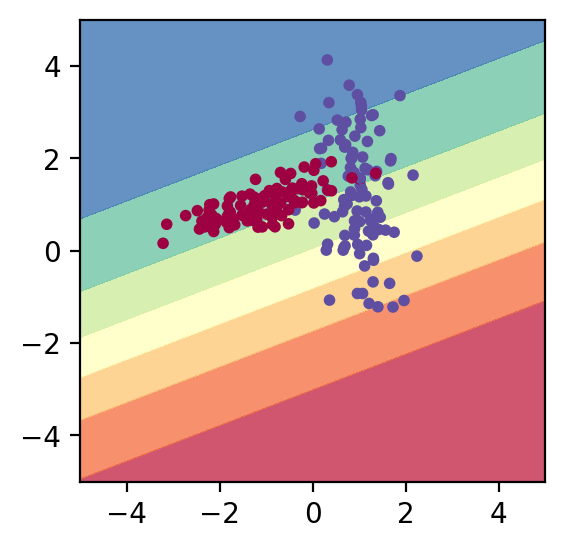

In [35]:
# filled contour of the decision boundary
plt.contourf(Xgrid[0], Xgrid[1] ,predict, cmap=plt.cm.Spectral, alpha=0.8)
# scatter plot of the training data
plt.scatter(X[:,0],X[:,1], c=Y, s=10, cmap=plt.cm.Spectral)

In the cell below, we run through 25 iterations. In each iteration, we plot the decision boundary (by making our model output predictions for every point in a grid) and then complete one training step.

If we did not want to visualise the decision boundary during the training process, we would simply have to run:

```python
train(25)
```

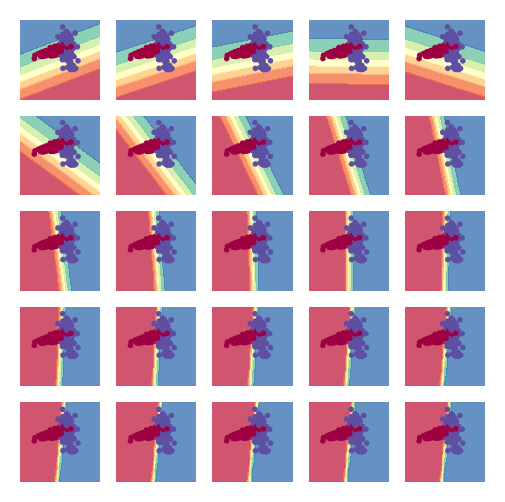

In [42]:
for i in range(1,26):
    ax = plt.subplot(5, 5, i)
    plt.axis('off')
    
    
    N=25
    Xgrid=np.meshgrid(np.linspace(-5, 5, N), np.linspace(-5, 5, N))
    Xgrid2=np.array([np.ndarray.flatten(Xgrid[0]), np.ndarray.flatten(Xgrid[1])])
    predict=model(torch.tensor(np.transpose(Xgrid2)).float()) # re-using our neuron function from earlier
    predict=predict.reshape( (N,N) ).detach()
    
    plt.contourf(Xgrid[0], Xgrid[1] ,predict, cmap=plt.cm.Spectral, alpha=0.8)
    # scatter plot of the training data
    plt.scatter(X[:,0],X[:,1], c=Y, s=1, cmap=plt.cm.Spectral)
    
    train(1)


We can plot the loss as a function of the number of epochs. Whilst the above plot shows qualitatively that the model improves over the training process, the plot below shows it quantitatively.

(0.0, 2.2716747254133223)

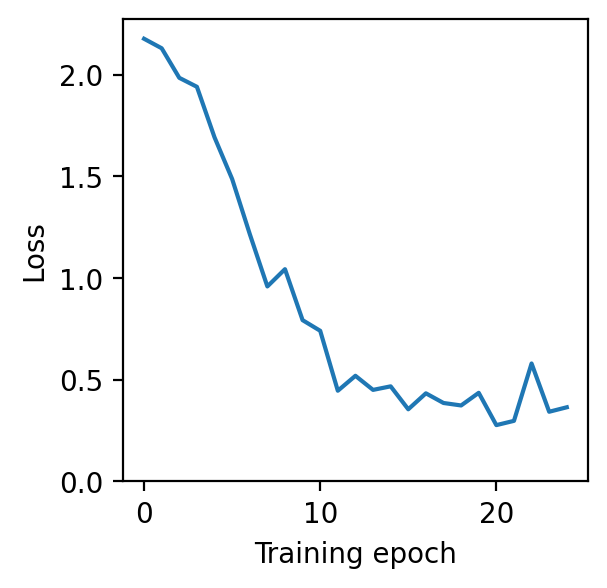

In [43]:
plt.plot(losses)
plt.xlabel("Training epoch")
plt.ylabel("Loss")
plt.ylim(0)

<div style="background-color:#C2F5DD">

What fraction of the training data do we correctly predict?

In [45]:
# Get predictions from the model
predictions = model(Xtorch)

# Apply threshold to convert probabilities to binary predictions (0 or 1)
predicted_labels = (predictions >= 0.5).float()

# Compare predictions to true labels
correct = (predicted_labels == Ytorch).float().sum()

# Calculate accuracy as the fraction of correct predictions
accuracy = correct / len(Ytorch)

print(f"Accuracy: {accuracy.item():.4f}")

Accuracy: 99.9700


We can view all of the model's parameters using the following code:


In [44]:
for name,param in model.named_parameters():
    print(name, param)

0.weight Parameter containing:
tensor([[10.3762, -1.0240]], requires_grad=True)
0.bias Parameter containing:
tensor([-0.9244], requires_grad=True)


## Experiment with manually setting weights

<div style="background-color:#C2F5DD">

The code block below allows us to maually set the weights of the model. Try and do this to correctly describe the data.

0.weight Parameter containing:
tensor([[0., 1.]], requires_grad=True)
0.bias Parameter containing:
tensor([0.], requires_grad=True)
Accuracy tensor(0.5043)


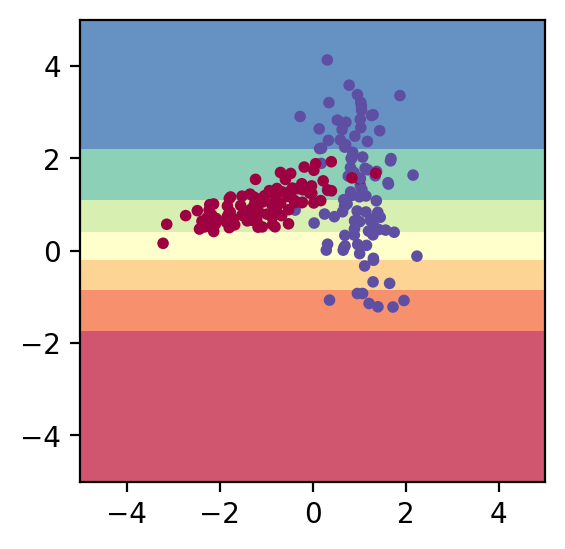

In [47]:
with torch.no_grad():
    model[0].weight[0,0]=0
    model[0].weight[0,1]=1
    model[0].bias[0]=0
    for name,param in model.named_parameters():
        print(name, param)
    
# make a grid of predictions, for plotting the decision boundary
N=100
Xgrid=np.meshgrid(np.linspace(-5, 5, N), np.linspace(-5, 5, N))
Xgrid2=np.array([np.ndarray.flatten(Xgrid[0]), np.ndarray.flatten(Xgrid[1])])
predict=model(torch.tensor(np.transpose(Xgrid2)).float()) # re-using our neuron function from earlier
predict=predict.reshape( (N,N) ).detach()

# filled contour of the decision boundary
plt.contourf(Xgrid[0], Xgrid[1] ,predict, cmap=plt.cm.Spectral, alpha=0.8)
# scatter plot of the training data
plt.scatter(X[:,0],X[:,1], c=Y, s=10, cmap=plt.cm.Spectral)

# Accuracy - what fraction of the train data go we correctly predict?
print("Accuracy",(Ytorch == torch.round(model(Xtorch))).float().mean())

We have now demonstrated the basic process for training a neural network in PyTorch. We have seen that, unlike in the previous notebook, we have not had to do many things 'by hand' - rather, PyTorch performs a lot of these tasks for us 'under the hood'. It may seem that what we had to do to train just a single neuron was quite a lot of work, however building and training a much larger network follows almost the same process with hardly any extra work. This is where PyTorch comes into its own.

<hr style="border:2px solid gray">

# Multilayer perceptron [^](#index) <a id='multi'></a>

From our work thus far, we can see that a single neuron is only capable of linearly separating the input data. 

Instead we can make a multi-layer perceptron, which goes beyond the capabilities of a single neuron. It also allows us to begin to learn a lower-dimensional representation of the data.

This is where the term 'deep' learning comes from, once you have a deep network of many artificial neuron layers.

## Backpropagation  <a id='backprop'></a>

Now that we have moved onto multilayer networks, it is worth introducing the concept of backpropagation. Previously, when we found the rate of change of the loss function with respect to a parameter of our model, it was straight-forward. Now our network has (an) extra layer(s), the derivative of the loss function with respect to a weight has a less simple form due to the interdependence of neurons in successive layers.

Consider the following example.

<img src="https://studymachinelearning.com/wp-content/uploads/2019/12/crop_NN.jpg" width="450" height="300" />



Say we want to find the gradient of the loss function with respect to the weight $w_{11}$. Labelling our Loss as $L$, we want to find $$\frac{\partial L}{\partial w_{11}}$$

Note that we $a_{ij}$ is defined as the result of passing the output of the $j^{th}$ neuron of the $i^{th}$ layer through the activation function, $\sigma_i$.

i.e., 

$$a_{ij} = \sigma_i(z_{ij})$$
$$z_{ij} = \boldsymbol{x} \cdot \boldsymbol{w_j} + b_{ij}$$

A change in $w_{11}$ does bring about a change in the loss function (provided we don't have a dead neuron, more on this next week), but not in a direct sense. Changing $w_{11}$ causes a change in $z_{11}$, which in turn causes a change in $a_{11}$, which changes $z_{21}$ etc...

<div style="background-color:#FFCCCB">

In order, then, to calculate a gradient for this parameter, we need to use the chain rule.

$$\frac{\partial L}{\partial w_{11}} = \frac{\partial L}{\partial a_{21}} 
                                       \frac{\partial a_{21}}{\partial z_{21}}
                                       \frac{\partial z_{21}}{\partial a_{11}}
                                       \frac{\partial a_{11}}{\partial z_{11}}
                                       \frac{\partial z_{11}}{\partial w_{11}}$$

</div>

We can see here how we traverse back through the network, hence the name **backpropagation** and the name of the `backward()` method in PyTorch.

In summary, to get the rate of change of the loss function with respect to a parameter, we need to know how, in turn, it changes with respect to everything which precedes it. This leads to chains of derivatives.

See the appendix for how PyTorch calculates gradients using the [backward()](#backward_app) function.

## Generate New Dataset

Now we will generate a dataset which is not linearly separable, and hence requires slightly more 'heavy machinery' than the single layer perceptron.

In [48]:
n_samples=200
np.random.seed(0)

In [49]:
X, Y = sklearn.datasets.make_gaussian_quantiles(mean=None, 
    cov=0.7, n_samples=n_samples, n_features=2, n_classes=2, 
    shuffle=True, random_state=None)

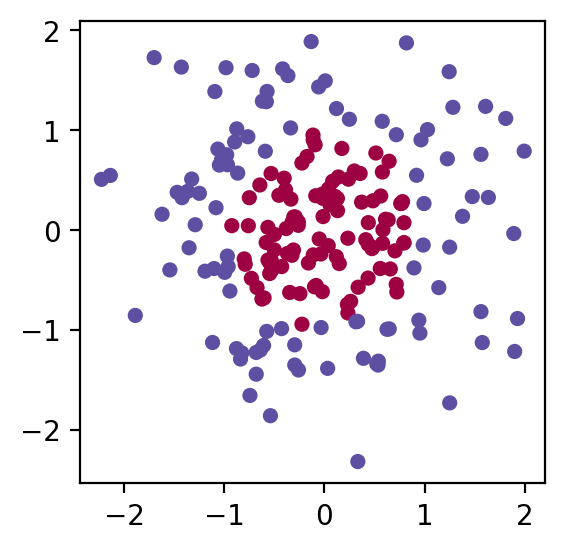

In [50]:
plt.scatter(X[:,0],X[:,1], c=Y, s=20, cmap=plt.cm.Spectral)

<div style="background-color:#C2F5DD">

- Construct your new neural network with a 30-neuron hidden layer using the convenient `nn.sequential` functionality, using the tips in the code cell below:
    
- Print the model.
    
</div>

Note: You are asked below to use another type of activation function called ReLU. It has the form $ f(x) = \max(0,x) =  \begin{cases}
x, & x > 0 \\
0, & x \leq 0
\end{cases}$

In PyTorch, we access it using `nn.ReLU`.

The specific use cases for ReLU and other activation functions are covered next week.

In [52]:
input_size=2 # two dimensional input
hidden_layer=30 # hidden layer
output_size=1 # one output

# PyTorch convenience class to define a sequential set of layers

model = nn.Sequential(
    # ... I suggest: 
    # Linear input -> hidden,
    # ReLU ,
    # Linear hidden -> output,
    # Sigmoid 
    # ...
    nn.Linear(input_size, hidden_layer), nn.ReLU(), nn.Linear(hidden_layer, output_size), nn.Sigmoid())

print(model)


Sequential(
  (0): Linear(in_features=2, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
  (3): Sigmoid()
)


The same as before, we can test that the model gives us outputs of the correct shape. Currently our model is untrained, so the values in the output do not have much meaning at this stage.

Inputting a datapoint with 2 arbitrary features should return a scalar.

In [53]:
model(torch.tensor([0.0,0.0])) 

tensor([0.4132], grad_fn=<SigmoidBackward0>)

# Training the Multilayer Network [^](#index) <a id='trainmulti'></a> 

A key advantage of PyTorch is that the training process stays largely the same regardless of the size of your network. All of the steps below were necessary for the previous single neuron example, and we have no extra work to do here. Using PyTorch is extremely scalable in this sense.

To be ready to train our network - as we did last time - we need to define our optimizer, prepare our dataloader, implement a training function and visualise our decision boundaries (not necessary to train out model, but we are doing it here).

<div style="background-color:#C2F5DD">

Define the same loss function as we used before.

In [54]:
lossfunction = nn.L1Loss() # mean absolute error loss function

Define the optimizer to use for this training process.

In [55]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.02) #lr = learning rate

Transform our data into the correct form, then instatiate the DataLoader class, to be used as our iterator in the training loop.

In [56]:
Xtorch = torch.tensor(X).float()
Ytorch = torch.tensor(Y).view(len(Y),1).float()
D=torch.utils.data.TensorDataset(Xtorch,Ytorch)
trainloader = torch.utils.data.DataLoader( D , batch_size=64, shuffle=True)

Training Function:

In [57]:
losses = []

def train(n): # train for this many epochs
    for i in range(n):
        totalloss=0
        for Xtorch,Ytorch in trainloader: # 1. pull a batch from the loader
            
            y=model(Xtorch) # 2. forward pass through model
            loss=loss_function(y, Ytorch) # 3. compute the loss
            totalloss+=loss.detach() # detach method tells the machine not to track the gradient of this tensor
            
            loss.backward() # 4. calculate backward (gradient) pass
            optimizer.step() # 5. use gradient info in optimise step
        
        losses.append(totalloss)

Make a grid of predictions, for plotting the decision boundary

In [58]:
N=400
Xgrid=np.meshgrid(np.linspace(-5, 5, N), np.linspace(-5, 5, N))
Xgrid2=np.array([np.ndarray.flatten(Xgrid[0]), np.ndarray.flatten(Xgrid[1])])
predict=model(torch.tensor(np.transpose(Xgrid2)).float()) # re-using our neuron function from earlier
predict=predict.reshape( (N,N) ).detach()

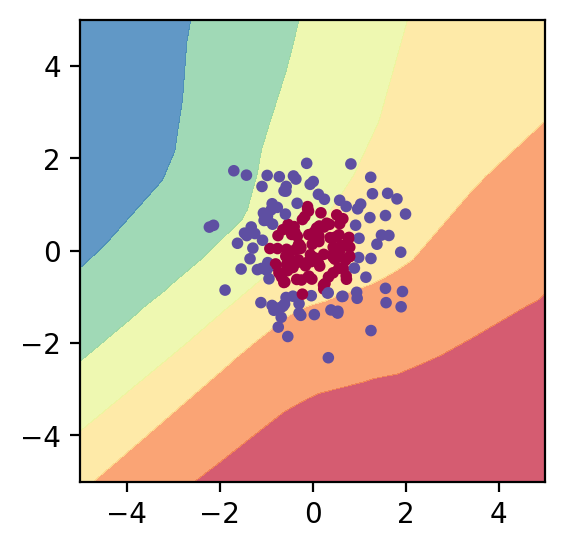

In [59]:
# filled contour of the decision boundary
plt.contourf(Xgrid[0], Xgrid[1] ,predict, cmap=plt.cm.Spectral, alpha=0.8)
# scatter plot of the training data
plt.scatter(X[:,0],X[:,1], c=Y, s=10, cmap=plt.cm.Spectral)

Training loop:

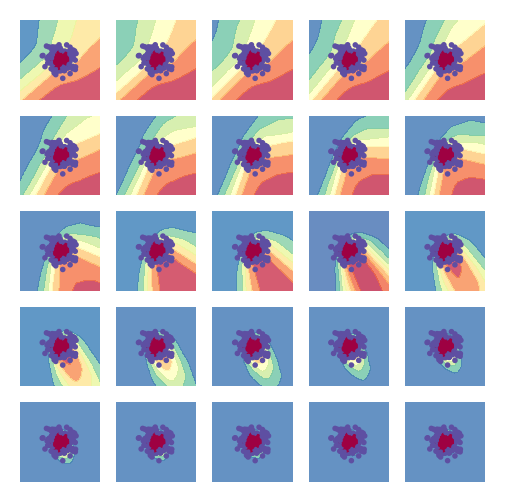

In [60]:
for i in range(1,26):
    ax = plt.subplot(5, 5, i)
    plt.axis('off')
    
    
    N=25
    Xgrid=np.meshgrid(np.linspace(-5, 5, N), np.linspace(-5, 5, N))
    Xgrid2=np.array([np.ndarray.flatten(Xgrid[0]), np.ndarray.flatten(Xgrid[1])])
    predict=model(torch.tensor(np.transpose(Xgrid2)).float()) # re-using our neuron function from earlier
    predict=predict.reshape( (N,N) ).detach()
    
    plt.contourf(Xgrid[0], Xgrid[1] ,predict, cmap=plt.cm.Spectral, alpha=0.8)
    # scatter plot of the training data
    plt.scatter(X[:,0],X[:,1], c=Y, s=1, cmap=plt.cm.Spectral)
    
    train(1)


(0.0, 2.0715581506490706)

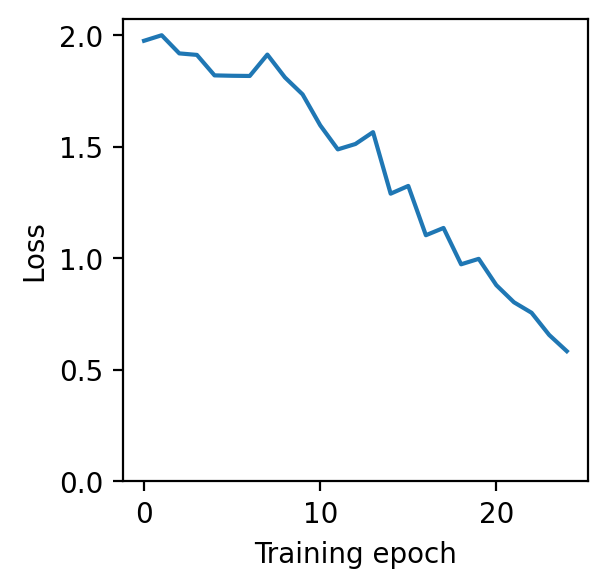

In [61]:
plt.plot(losses)
plt.xlabel("Training epoch")
plt.ylabel("Loss")
plt.ylim(0)

<div style="background-color:#C2F5DD">

Print the accuracy of the model.

In [62]:
# Get predictions from the model
predictions = model(Xtorch)

# Apply threshold to convert probabilities to binary predictions (0 or 1)
predicted_labels = (predictions >= 0.5).float()

# Compare predictions to true labels
correct = (predicted_labels == Ytorch).float().sum()

# Calculate accuracy as the fraction of correct predictions
accuracy = correct / len(Ytorch)

print(f"Accuracy: {accuracy.item():.4f}")

Accuracy: 0.9450


Again we can inspect the model parameters. Note the difference in number of parameters to our previous, smaller network.

In [63]:
model(Xtorch)

tensor([[0.0082],
        [0.9863],
        [0.0102],
        [0.3026],
        [0.4737],
        [0.0084],
        [0.0258],
        [0.8760],
        [0.9955],
        [0.0085],
        [0.9412],
        [0.9864],
        [0.9745],
        [0.0223],
        [0.9265],
        [0.9995],
        [0.1382],
        [0.9944],
        [0.3298],
        [0.9977],
        [0.8790],
        [0.1566],
        [0.1167],
        [0.8376],
        [0.9843],
        [0.2104],
        [0.2401],
        [0.4017],
        [0.0141],
        [0.1638],
        [0.2284],
        [0.0771],
        [0.8317],
        [0.1219],
        [0.2108],
        [0.9992],
        [0.9087],
        [0.9927],
        [1.0000],
        [0.0357],
        [0.0340],
        [0.1252],
        [0.1051],
        [0.9462],
        [0.9727],
        [0.5828],
        [0.9794],
        [0.8796],
        [0.0872],
        [0.4049],
        [0.6853],
        [0.0102],
        [0.9476],
        [0.0736],
        [0.6469],
        [0

# Conclusion  <a id='conc'></a> [^](#index)

This week we started by building a neuron from scratch, using no machine learning specific modules. We discovered the need for activation functions as part of a neuron because of the non-linearity they create.
Moving onto PyTorch, we learned about the fundamental datatype, the tensor, which PyTorch works with. We found that we can just as easily create a single neuron binary classifier, using the PyTorch package. This approach turned out to be easily scalable to larger networks which can deal with more complicated datasets. It is worth noting that, whilst all of this analysis was carried out on 2-dimensional datasets, this was purely for ease of visualisation: real-life use cases tackle problems in many more dimensions. 

Next week, we look in more detail at the role of activation functions, when to use each type, and why choosing the correct one is very important. In the process, we will be building on what we have learned about PyTorch thus far, and applying it to even larger networks with one or more hidden layers.

<hr style="border:2px solid gray">
<hr style="border:2px solid gray">

<div style="background-color:#efdff2">

# Appendix [^](#index) <a id='app'></a>
    
[Return to Index](#index)

In this section, you will find longer pieces of mathematics and code which are **non-examinable**. Please read at your own discretion.

- A [Coordinate Transformation](#coord)
- B [PyTorch backward() Function](#backward_app) 

<hr style="border:2px solid gray">

<div style="background-color:#efdff2">

# A: Coordinate Transformation

Previously, we saw how we need more neurons, in the form of a hidden layer, in order to deal with classification problems where are training data are less 'nicely separated'.

An equally valid way to negotiate this issue is to perform a coordinate transformation on our data. This approach adds only a constant amount to our total computation time: we transform the data before our iterative training process, so there are no time-scaling issues. In fact, a reason to transform our training data would be to speed up the training process. If, in our new coordinate system, the data is again linearly separable, then we require a less complex model with fewer parameters and hence the training process is much less computationally expensive.

<div style="background-color:#efdff2">

As before, we will go through the same process of generating and visualising data.

In [ ]:
n_samples=200
np.random.seed(0) # reproducible runs for debugging

In [ ]:
# generate data as before

X, Y = sklearn.datasets.make_gaussian_quantiles(mean=None, 
    cov=0.7, n_samples=n_samples, n_features=2, n_classes=2, 
    shuffle=True, random_state=None)

<div style="background-color:#efdff2">

Upon inspection, our data is not linearly separable in $(x,y)$ space, but it looks like our data may be linearly separable in $(r,\theta)$ space: for $r<1$, almost all of the data belongs to the same category and for $r>1$, all belongs to the other category. 

We will inspect our data, and subsquently visualise it in $(r,\theta)$ space.

In [ ]:
plt.scatter(X[:,0],X[:,1], c=Y, s=20, cmap=plt.cm.Spectral)
xcirc = np.linspace(1,-1,100)
ycirc = np.sqrt(1-xcirc**2)
plt.plot(xcirc, ycirc, color='green', label='$r=1$')
plt.plot(xcirc, -ycirc, color='green')
plt.legend()

<div style="background-color:#efdff2">

The cell below performs the coordinate transformation:
    
In each row of the array, we have $[r, \theta]$ for that datapoint.

In [ ]:
rtheta = np.array([[np.sqrt(x**2 + y**2), np.arctan2(y,x)] for x, y in X])

<div style="background-color:#efdff2">

Now when we plot in the transformed space, we can see that the data looks linearly separable at approximately $r=1$.

In [ ]:
# plot transformed data
plt.scatter(rtheta[:,0],rtheta[:,1], c=Y, s=10, cmap=plt.cm.Spectral)

# overlay a line of constant r
plt.plot([1,1],[-3.2, 3.2], color='green', label='$r=1$')
plt.xlabel(r'$r$')
plt.ylabel(r'$\theta$')
plt.legend()

<div style="background-color:#efdff2">

The advantage of transforming our data is that we can revert back to our simple binary classifier consisting of a single neuron. This is much more computationally efficient and makes our model much faster to train.

<div style="background-color:#efdff2">

We will now see if the single neuron perceptron is capable of achieving what we did previously with a network consisting of a 30-neuron hidden layer.

In [ ]:
input_size=2 # two dimensional input
output_size=1 # one output

model = nn.Sequential(nn.Linear(input_size,output_size), nn.Sigmoid())

print(model)


<div style="background-color:#efdff2">

Following the exact same process as before, we define our loss function, optimizer and our dataloader. We define a training function and use it in a for loop whilst plotting our updated decision boundary as the number of training epochs increases.

In [ ]:
# See https://pytorch.org/docs/stable/nn.html#loss-functions

loss_function = nn.L1Loss()

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.02) #lr = learning rate

In [ ]:
rtheta_torch = torch.tensor(rtheta).float()
Y_torch = torch.tensor(Y).view(len(Y),1).float()
D=torch.utils.data.TensorDataset(rtheta_torch,Y_torch)

trainloader = torch.utils.data.DataLoader( D , batch_size=64, shuffle=True)

In [ ]:
losses = []

def train(n): # train for this many epochs
    for i in range(n):
        totalloss=0
        for rtheta_torch, Y_torch in trainloader: # 1. pull a 'batch' of from the loader
            
            y=model(rtheta_torch) # 2. forward pass through model
            loss=loss_function(y, Y_torch) # 3. compute the loss
            totalloss+=loss.detach() # detach method tells the machine not to track the gradient of this tensor
            
            loss.backward() # 4. calculate backward (gradient) pass
            optimizer.step() # 5. use gradient info in optimise step
        
        losses.append(totalloss)

<div style="background-color:#efdff2">

Make a grid of predictions, for plotting the decision boundary:

In [ ]:
N=400
Xgrid=np.meshgrid(np.linspace(-5, 5, N), np.linspace(-5, 5, N))
Xgrid2=np.array([np.ndarray.flatten(Xgrid[0]), np.ndarray.flatten(Xgrid[1])])
predict=model(torch.tensor(np.transpose(Xgrid2)).float()) 
predict=predict.reshape( (N,N) ).detach()

In [ ]:
# filled contour of the decision boundary
plt.contourf(Xgrid[0], Xgrid[1] ,predict, cmap=plt.cm.Spectral, alpha=0.8)
# scatter plot of the training data
plt.scatter(rtheta[:,0],rtheta[:,1], c=Y, s=10, cmap=plt.cm.Spectral)

In [ ]:
for i in range(1,26):
    ax = plt.subplot(5, 5, i)
    plt.axis('off')
    
    
    N=25
    Xgrid=np.meshgrid(np.linspace(-5, 5, N), np.linspace(-5, 5, N))
    Xgrid2=np.array([np.ndarray.flatten(Xgrid[0]), np.ndarray.flatten(Xgrid[1])])
    predict=model(torch.tensor(np.transpose(Xgrid2)).float()) # re-using our neuron function from earlier
    predict=predict.reshape( (N,N) ).detach()
    
    plt.contourf(Xgrid[0], Xgrid[1] ,predict, cmap=plt.cm.Spectral, alpha=0.8)
    # scatter plot of the training data
    plt.scatter(rtheta[:,0],rtheta[:,1], c=Y, s=1, cmap=plt.cm.Spectral)
    
    train(1)

<div style="background-color:#efdff2">

It looks like our model has been able to complete the same task as before, but using a much less computationally intensive model, by transforming our data.

We will inspect our graph of loss and determine our final accuracy to verify this.

In [ ]:
plt.plot(losses)
plt.xlabel("Training epoch")
plt.ylabel("Loss")
plt.ylim(0)

<div style="background-color:#efdff2">
    
Finally, we will print the accuracy of this model.

In [ ]:
print("Accuracy",(Y_torch == torch.round(model(rtheta_torch))).float().mean())

<hr style="border:2px solid gray">

<div style="background-color:#efdff2">

## B. PyTorch backward() Function [^^](#app) <a id='backward_app'></a>
    
[Return to Backpropagation](#backprop)     
    
_References: [tutorialspoint](https://www.tutorialspoint.com/how-to-compute-gradients-in-pytorch), PyTorch: [A Gentle Introduction to torch.autograd](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html), Medium: Abishek Bashyall - [Playing with .backward() method in Pytorch](https://abishekbashyall.medium.com/playing-with-backward-method-in-pytorch-bd34b58745a0)_
    
_For further explanation, click [here](https://stackoverflow.com/questions/57320830/why-torch-sum-before-doing-backward) and [here](https://stackoverflow.com/questions/57248777/backward-function-in-pytorch/57249287#57249287) to view two Stack Overflow discussions_
    
PyTorch is designed to create neural networks, where calculating the gradient in back propagation is vital. Therefore when we create a Torch tensor, we can specify if it is a variable from which we would like to calculate the derivatives. We do this by setting `requires_grad = True` (it is False by default). 
    
To calculate the gradient of a function wrt this variable, we must then call the `autograd.backward()` (or just `backward()` function on our output. Two such examples are given below.

In [ ]:
x = torch.tensor(5., requires_grad=True)
y = x**2
y.backward()
print (x.grad) # Expect 2*x = 10

In [ ]:
x = torch.tensor(3., ) # We would not need this gradient for back propagation

w = torch.tensor(2.0, requires_grad = True)
b = torch.tensor(5.0, requires_grad = True)

y = w * x + b
print("y:", y)

# Compute gradients by calling backward function for y
y.backward()

# Access and print the gradients w.r.t x, w, and b
dx = x.grad
dw = w.grad
db = b.grad
print("x.grad :", dx) # We did not require a gradient for this variable
print("w.grad :", dw) # Expect x = 3
print("b.grad :", db) # Expect 1

<div style="background-color:#efdff2">

We can see what happens if we have a function act on another, for example by multiplying our input y by 2. Unlike w and b, we will be unable to perform y.grad as y is not a **leaf nodes**; it is calculated from a function of leaf node. Hence we will obtain an error. If we did want to find the gradient wrt y, we would use the `retain_grad()` method.

In [ ]:
x = torch.tensor(3., ) # We would not need this gradient for back propagation

w = torch.tensor(2.0, requires_grad = True)
b = torch.tensor(5.0, requires_grad = True)

y = w * x + b

# Uncomment the line below to retain the gradient
#y.retain_grad()

z = 2 * y

z.backward()

db = b.grad
dw = w.grad
dy = y.grad

print("w.grad :", dw) # Expect x = 6
print("b.grad :", db) # Expect 2
print("y.grad :", dy) # Expect 2


<div style="background-color:#efdff2">

By default, `backward()` is called on a scalar tensor since the function is unable to calculate non-scalar derivatives. If the output is not of this form, the code will not run. An example of this is given below.

In [ ]:
x_arr = torch.tensor([1., 2., 3.], requires_grad=True)
y_arr= x_arr ** 2 
y_arr.backward()

<div style="background-color:#efdff2">
    
One way to get past this would be to simply create a scalar tensor that would make backwards() produce the required gradients - for example the sum of all the elements in our output vector: $\Sigma y_i^{(j)}$. Since this sum is unweighted, this method can be described as that of _equal gradient flow_. Note that our output elements $y_i^{(j)}$ only depend on $x_i^{(j)}$:
    
\begin{equation}    
\frac{\partial}{\partial x_k^{(l)}} \sum y_i^{(j)} = \sum \frac{\partial f(x_i^{(j)})}{\partial x_k^{(l)}} = \frac{\partial f(x_k^{(l)})}{\partial x_k^{(l)}}
\end{equation}    
    
`x.grad` would then produce a torch tensor containing all of these derivatives, as required.

In [ ]:
x = torch.tensor([[1.,2.,3.],[4.,5.,6.]], requires_grad=True)
print (x)
print ()

# Imaging that squaring our data is the activation function
# This would means the gradient should be given by 2*x
out = x**2 
out.sum().backward()


print(x.grad) # This should be 2*input values

<div style="background-color:#efdff2">
    
An alternative way to achieve our desired outcome is by setting the gradient argument in the backward() function. Understanding the principles behind why this works requires knowledge of PyTorch's autograd function. 
    
First, imagine our function is of the form $\boldsymbol{y} = f (\boldsymbol{x})$, where **x** and **y** have size n and m respectively. 
   
When we call `backward()`, we are actually calling the default `backward(gradient = torch.tensor[1.])`. We will refer to this gradient using $\boldsymbol{v}$.. Autograd then performs the following calculations, where J is the **Jacobian**:
    
\begin{equation}
    J^T \cdot \boldsymbol{v} =
                              \begin{bmatrix} 
                              \frac{\partial y_1}{\partial x_1} & \dots  & \frac{\partial y_m}{\partial x_1}\\
                                    \vdots & \ddots & \vdots\\
                              \frac{\partial y_1}{\partial x_n} & \dots  & \frac{\partial y_m}{\partial x_n} 
                              \end{bmatrix} \boldsymbol{v}
\end{equation}
    
If **x** and **y** were the same size, and $y_i$ only depended on $x_i$, we would just have a diagonal matrix. By setting **v** to be the same size as **x** and only contain ones, we would get the equation we were after. We can also see how the simple 1D equation works:
    
\begin{equation}
    \begin{bmatrix} 
          \frac{\partial y_1}{\partial x_1} & \dots  & 0 \\ \vdots & \ddots & \vdots \\ 0 & \dots  & \frac{\partial y_m}{\partial x_m} 
    \end{bmatrix} 
    \begin{pmatrix} 
          1 \\ \vdots \\ 1 
    \end{pmatrix} = 
                    \begin{pmatrix} 
                          \frac{\partial y_1}{\partial x_1} \\ \vdots \\ \frac{\partial y_m}{\partial x_m} 
                    \end{pmatrix}
\end{equation}
    
If X and Y are matrices rather than vectors, then we can imagine the autograd function working on each column (or row) in turn. The gradient called by backward() must still have the same shape as the matrices X and Y. An example of this is shown below:

In [ ]:
x = torch.tensor([[1.,2.,3.],[4.,5.,6.]], requires_grad=True)
print (x)
print ()

out = x**2 
out.backward(gradient = torch.ones_like(x))

print(x.grad) # This should be 2*input values
